###Creating AML Monitoring System

In [ ]:
#Assign the best model
model = models[best_model]

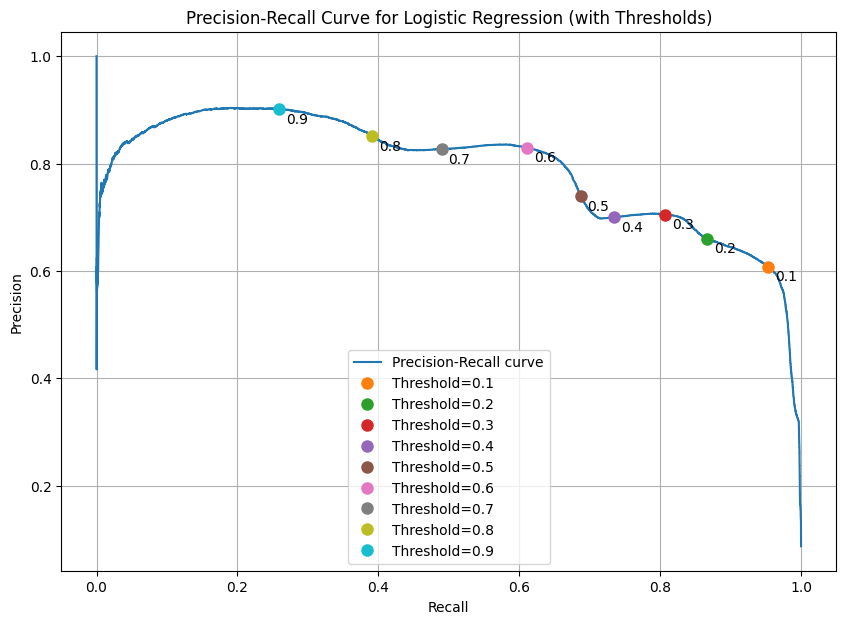

In [ ]:
#Threshold optimization based on business needs

y_pred_proba_lr = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_lr)

plt.figure(figsize=(10, 7))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression (with Thresholds)')
plt.grid(True)

for t in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    idx = np.argmin(np.abs(thresholds - t))
    plt.plot(recall[idx], precision[idx], 'o', markersize=8, label=f'Threshold={t:.1f}')
    plt.annotate(f'{t:.1f}', (recall[idx], precision[idx]), textcoords="offset points", xytext=(5,-10))

plt.legend()
plt.show()

In [ ]:
#Calculating the risk_scores for test set
risk_scores = model.predict_proba(X_test)[:,1]

#Assigning risk threshholds
risk_thresholds = {'low':0.3,'medium':0.7,'high':0.9}

In [ ]:
#Creating the monitoring dashboard data
monitoring_data = pd.DataFrame({
    'transaction_id': range(len(risk_scores)),
    'risk_score': risk_scores,
    'actual_fraud': y_test.values,
    'risk_level': pd.cut(risk_scores,
                         bins=[0,risk_thresholds['low'],
                               risk_thresholds['medium'],
                               risk_thresholds['high'],1],
                         labels=['Low','Medium','High','Critical'])
})

In [ ]:
#Creating an AML rules engine
def apply_aml_rules(row):
  rules_triggered = []

  if row['risk_score'] > risk_thresholds['high']:
    rules_triggered.append('HIGH RISK SCORE')

  if row['risk_level'] == 'Critical':
    rules_triggered.append('CRITICAL RISK LEVEL')

  return '|'.join(rules_triggered) if rules_triggered else 'NO ALERT'

monitoring_data['aml_alerts'] = monitoring_data.apply(apply_aml_rules,axis=1)

In [ ]:
#Generating monitoring report
print("\n AML Monitoring Report")
print(f"Total Transaction Monitored: {len(monitoring_data)}")
print("\n Risk Level Distribution:")
print(monitoring_data['risk_level'].value_counts())

print("\n AML Alerts Summary:")
alert_summary = monitoring_data['aml_alerts'].value_counts()
print(alert_summary)


 AML Monitoring Report
Total Transaction Monitored: 300000

 Risk Level Distribution:
risk_level
Low         269974
Medium       14495
High          7981
Critical      7550
Name: count, dtype: int64

 AML Alerts Summary:
aml_alerts
NO ALERT                               292450
HIGH RISK SCORE|CRITICAL RISK LEVEL      7550
Name: count, dtype: int64


In [ ]:
#Detect High risk transactions requiring manual review
high_risk_transactions = monitoring_data[monitoring_data['risk_score']>risk_thresholds['high']]
print(f"\n Transactions requiring manual review: {len(high_risk_transactions)}")


 Transactions requiring manual review: 7550


In [ ]:
#Performance metrics for monitoring system
true_positives = len(monitoring_data[(monitoring_data['risk_score'] > risk_thresholds['medium']) &
                                 (monitoring_data['actual_fraud'] == 1)])
false_positives = len(monitoring_data[(monitoring_data['risk_score'] > risk_thresholds['medium']) &
                                     (monitoring_data['actual_fraud'] == 0)])

precision = true_positives / (true_positives + false_positives)

In [ ]:
print("\n Monitoring System Performance")
print(f"Alert Precision: {precision: .3f}")
print(f"Detection Rate: {true_positives / monitoring_data['actual_fraud'].sum():.3f}")


 Monitoring System Performance
Alert Precision:  0.827
Detection Rate: 0.490


In [ ]:
monitoring_data

,transaction_id,risk_score,actual_fraud,risk_level,aml_alerts
0,0,0.016522,0.0,Low,NO ALERT
1,1,0.000020,0.0,Low,NO ALERT
2,2,0.000411,0.0,Low,NO ALERT
3,3,0.002925,0.0,Low,NO ALERT
4,4,0.662693,1.0,Medium,NO ALERT
...,...,...,...,...,...
299995,299995,0.012381,0.0,Low,NO ALERT
299996,299996,0.000586,0.0,Low,NO ALERT
299997,299997,0.000069,0.0,Low,NO ALERT
299998,299998,0.011803,0.0,Low,NO ALERT


In [ ]:
monitoring_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype   
---  ------          --------------   -----   
 0   transaction_id  200000 non-null  int64   
 1   risk_score      200000 non-null  float64 
 2   actual_fraud    200000 non-null  float64 
 3   risk_level      200000 non-null  category
 4   aml_alerts      200000 non-null  object  
dtypes: category(1), float64(2), int64(1), object(1)
memory usage: 6.3+ MB


In [ ]:
def calculate_business_impact(monitoring_data: pd.DataFrame):
    avg_fraud_loss = 150
    fp_cost = 2

    detected_frauds = len(monitoring_data[(monitoring_data['risk_score'] > 0.7) &
                                          (monitoring_data['actual_fraud'] == 1)])

    prevented_losses = detected_frauds * avg_fraud_loss
    operational_costs = len(monitoring_data[monitoring_data['risk_score'] > 0.7]) * fp_cost

    roi = (prevented_losses - operational_costs) * operational_costs * 100

    print("Business Impact:")
    print(f"Frauds Detected : {detected_frauds}")
    print(f"Losses Prevented: ${prevented_losses:,}")
    print(f"ROI: {roi: .1f}%")

In [ ]:
calculate_business_impact(monitoring_data)

Business Impact:
Frauds Detected: 8638
Losses Prevented: $1,295,700
ROI: 6121.0%


In [ ]:
#Create function that checks model drift on new data
def monitor_model_drift(new_data):
    # Compare feature distributions
    drift_detected = []

    for feature in ['distance_from_home', 'ratio_to_median_purchase_price']:
        original_mean = df[feature].mean()
        new_mean = new_data[feature].mean()

        drift_pct = abs(new_mean - original_mean) / original_mean * 100

        if drift_pct > 20:  # 20% threshold
            drift_detected.append(feature)

    if drift_detected:
        print(f"⚠️ Model Drift Detected in: {drift_detected}")
        print("Recommendation: Retrain model")
    else:
        print("✅ No significant drift detected")

In [ ]:
#We check on existing data
monitor_model_drift(df)

✅ No significant drift detected
